In [12]:
# ================================
# Local Projection Analysis – Vietnam (Full shocks + PCA AI Index)
# ================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --------------------------
# 1. Load dataset
# --------------------------
data = pd.read_excel("vn_analysis_panel_full_2014_2023.xlsx")
data["Date"] = pd.to_datetime(data["Date"])

# --------------------------
# 2. Construct Monetary Policy Shocks (FULL specification)
# --------------------------
# Policy rate proxy = overnight interbank rate
y = data["avg_VNIBOR_ON"]

# FULL control set: domestic + global
controls_full = [
    "IIP_yoy_pct", "CPI_yoy_pct", "Credit_yoy_pct",
    "avg_VND_USD_rate", "NEER", "REER", "VN10Y",
    "FEDFUNDS", "WuXia_shadow_rate", "US10Y", "VIX", "DXY",
    "Brent_oil_price", "Global_food_price"
]

X_full = sm.add_constant(data[controls_full])
model_full = sm.OLS(y, X_full, missing="drop").fit()
data["mp_shock"] = model_full.resid  # identified policy shocks

# --------------------------
# 3. Construct New AI Adoption Index (PCA)
# --------------------------
# Google Trends (monthly, 16 keywords, 2013–2024)
df_trends = pd.read_csv("google_trends_combined_2013_2024.csv", encoding="latin1")
df_trends["Date"] = pd.to_datetime(df_trends["Date"])

# PCA on Google Trends
trends_keywords = df_trends.drop(columns=["Date"])
scaler = StandardScaler()
trends_scaled = scaler.fit_transform(trends_keywords)
pca_trends = PCA(n_components=1)
df_trends["AI_trends_PC1"] = pca_trends.fit_transform(trends_scaled).flatten()

# Publications + Investment (annual)
df_pub_inv = pd.read_excel("Vietnam_AI_inv_pub.xlsx")
df_pub_inv["AI_publications_z"] = StandardScaler().fit_transform(
    np.log1p(df_pub_inv["AI_publications"]).values.reshape(-1,1)
)
df_pub_inv["AI_investment_z"] = StandardScaler().fit_transform(
    np.log1p(df_pub_inv["AI_investment"]).values.reshape(-1,1)
)

# Expand annual -> monthly
df_pub_inv_monthly = pd.DataFrame({
    "Date": pd.date_range(start=f"{df_pub_inv['Year'].min()}-01-01",
                          end=f"{df_pub_inv['Year'].max()}-12-01", freq="MS")
})
df_pub_inv_monthly["Year"] = df_pub_inv_monthly["Date"].dt.year
df_pub_inv_monthly = df_pub_inv_monthly.merge(
    df_pub_inv[["Year","AI_publications_z","AI_investment_z"]],
    on="Year", how="left"
)

# Merge with Trends
df_ai = df_trends[["Date","AI_trends_PC1"]].merge(
    df_pub_inv_monthly[["Date","AI_publications_z","AI_investment_z"]],
    on="Date", how="left"
).dropna()

# PCA across all 3 dimensions
X = df_ai[["AI_trends_PC1","AI_publications_z","AI_investment_z"]]
X_scaled = StandardScaler().fit_transform(X)
df_ai["AI_index_PCA"] = PCA(n_components=1).fit_transform(X_scaled)

# Merge into macro dataset
df = pd.merge(data, df_ai[["Date","AI_index_PCA"]], on="Date", how="left")
df = df.sort_values("Date").set_index("Date")

# --------------------------
# 4. Local Projection Function
# --------------------------
def local_projection(dep_var, shock_var='mp_shock',
                     controls=['Credit_yoy_pct'], horizons=[1,3,6],
                     interactions=[]):
    results = {}
    for h in horizons:
        temp = df.copy()
        temp[f'{dep_var}_chg{h}'] = temp[dep_var].shift(-h) - temp[dep_var].shift(-1)
        y_h = temp[f'{dep_var}_chg{h}']
        X_h = pd.DataFrame({'shock': temp[shock_var]})
        for inter in interactions:
            X_h[f'shock_x_{inter}'] = temp[shock_var] * temp[inter]
        X_h['lag_dep'] = temp[dep_var].shift(1)
        for c in controls:
            X_h[c] = temp[c]
        X_h = sm.add_constant(X_h)
        model = sm.OLS(y_h, X_h, missing="drop").fit(
            cov_type="HAC", cov_kwds={"maxlags":h}
        )
        results[h] = model
    return results

# --------------------------
# 5. Run Models
# --------------------------
lp_output = local_projection('IIP_yoy_pct', controls=['Credit_yoy_pct'])
lp_infl   = local_projection('CPI_yoy_pct', controls=['Credit_yoy_pct'])

# Extended with Age65
lp_output_age = local_projection('IIP_yoy_pct', interactions=['Age65'])
lp_infl_age   = local_projection('CPI_yoy_pct', interactions=['Age65'])

# Extended with AI index
lp_output_ai = local_projection('IIP_yoy_pct', interactions=['AI_index_PCA'])
lp_infl_ai   = local_projection('CPI_yoy_pct', interactions=['AI_index_PCA'])

# --------------------------
# 6. Save IRFs to PDF
# --------------------------
def add_lp_results_to_pdf(pdf, results_dict, var_name, interaction=None):
    horizons = sorted(results_dict.keys())
    irfs, se = [], []
    for h in horizons:
        irfs.append(results_dict[h].params['shock'])
        se.append(results_dict[h].bse['shock'])
    irfs, se = np.array(irfs), np.array(se)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.axhline(0, color="black", linewidth=1)
    ax.errorbar(horizons, irfs, yerr=1.96*se, fmt='o-', capsize=4)
    title = f"IRF of {var_name} to Monetary Shock"
    if interaction: title += f" (interaction with {interaction})"
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Horizon (months)")
    ax.set_ylabel("Response")
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

with PdfPages("LP_results_report_full_shocks_AI.pdf") as pdf:
    add_lp_results_to_pdf(pdf, lp_output, "Industrial Output (IIP)")
    add_lp_results_to_pdf(pdf, lp_infl, "Inflation (CPI)")
    add_lp_results_to_pdf(pdf, lp_output_age, "Industrial Output (IIP)", "Age65")
    add_lp_results_to_pdf(pdf, lp_infl_age, "Inflation (CPI)", "Age65")
    add_lp_results_to_pdf(pdf, lp_output_ai, "Industrial Output (IIP)", "AI_index_PCA")
    add_lp_results_to_pdf(pdf, lp_infl_ai, "Inflation (CPI)", "AI_index_PCA")

print("Report created: LP_results_report_full_shocks_AI.pdf")


Report created: LP_results_report_full_shocks_AI.pdf


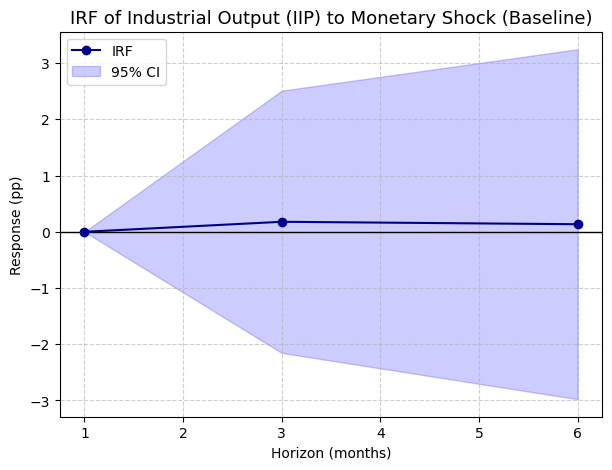

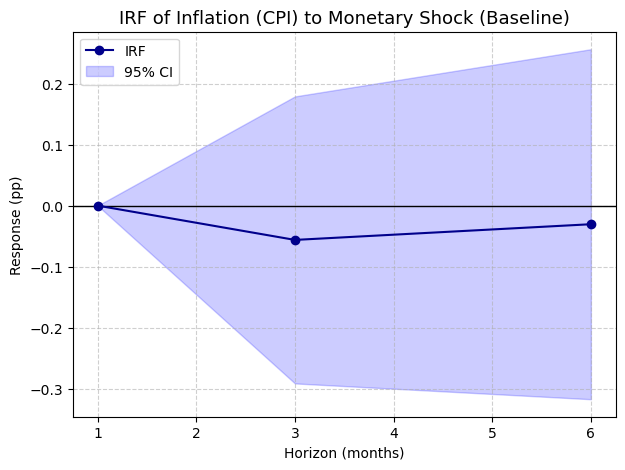

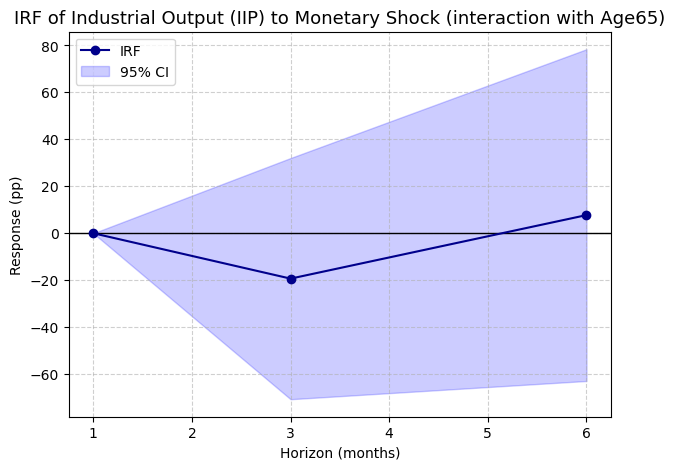

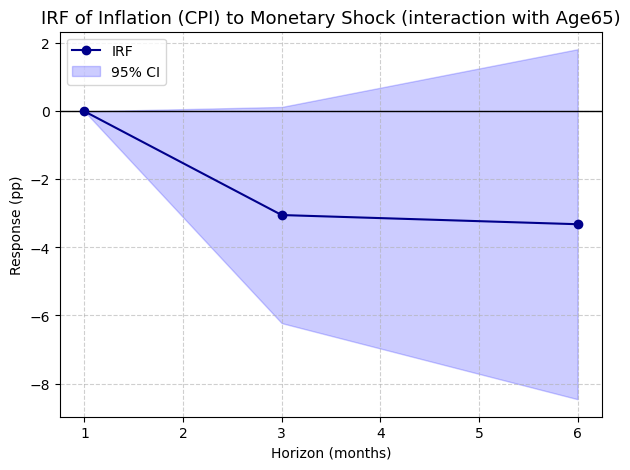

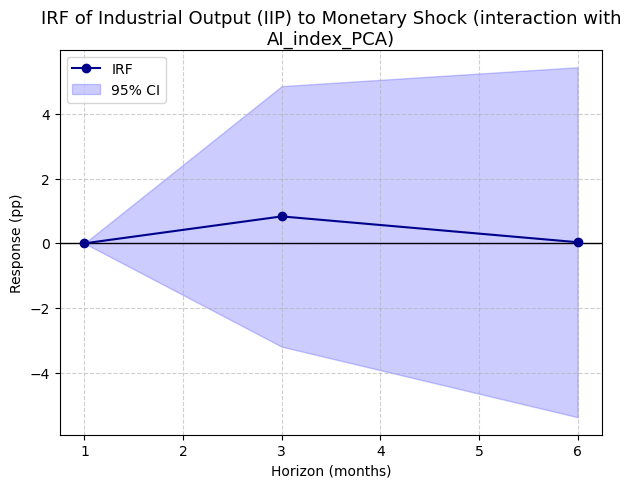

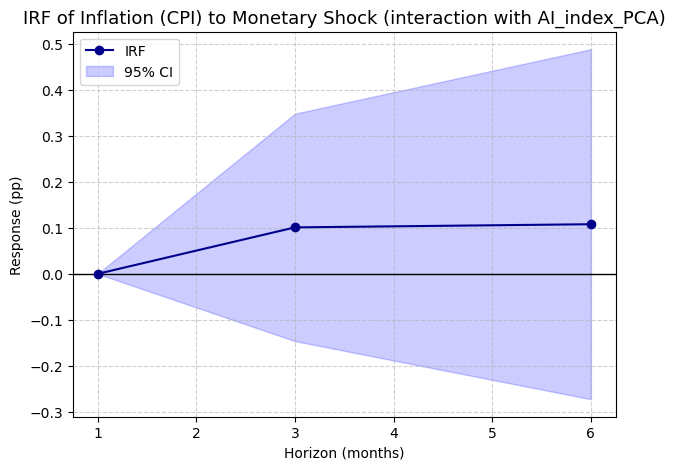

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot IRFs with shaded confidence bands
def plot_irf(lp_results, title):
    horizons = sorted(lp_results.keys())
    irfs = [lp_results[h].params['shock'] for h in horizons]
    se = [lp_results[h].bse['shock'] for h in horizons]
    irfs, se = np.array(irfs), np.array(se)

    plt.figure(figsize=(7,5))
    plt.axhline(0, color="black", linewidth=1)
    plt.plot(horizons, irfs, marker="o", color="darkblue", label="IRF")
    plt.fill_between(horizons, irfs-1.96*se, irfs+1.96*se,
                     color="blue", alpha=0.2, label="95% CI")
    plt.title(title, fontsize=13, wrap=True)
    plt.xlabel("Horizon (months)")
    plt.ylabel("Response (pp)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# --- Now draw all 6 figures ---

# Baseline
plot_irf(lp_output, "IRF of Industrial Output (IIP) to Monetary Shock (Baseline)")
plot_irf(lp_infl,   "IRF of Inflation (CPI) to Monetary Shock (Baseline)")

# With Age65
plot_irf(lp_output_age, "IRF of Industrial Output (IIP) to Monetary Shock (interaction with Age65)")
plot_irf(lp_infl_age,   "IRF of Inflation (CPI) to Monetary Shock (interaction with Age65)")

# With AI adoption
plot_irf(lp_output_ai, "IRF of Industrial Output (IIP) to Monetary Shock (interaction with AI_index_PCA)")
plot_irf(lp_infl_ai,   "IRF of Inflation (CPI) to Monetary Shock (interaction with AI_index_PCA)")
